In [1]:
import sys
from pathlib import Path
proj_root = Path().resolve().parent  # adjust if needed
print(proj_root)
sys.path.insert(0, str(proj_root))

/work/users/t/i/tis/mmai/ManiSkill2_real2sim/mani_skill2_real2sim


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from transforms3d.euler import euler2quat
import gymnasium as gym
from sapien.core import Pose
from mani_skill2_real2sim.utils.sapien_utils import look_at
from mani_skill2_real2sim.envs.sapien_env import BaseEnv

In [2]:
env_id = "MoveNearGoogleInScene-v0"
env_id = "MoveNearWithCustomOverlayEnv"
pose = look_at([1.0, 1.0, 2.0], [0.0, 0.0, 0.7])

env: BaseEnv = gym.make(
    env_id,
    obs_mode="rgbd",
    reward_mode=None,
    control_mode="arm_pd_ee_delta_pose_align_interpolate_by_planner_gripper_pd_joint_target_delta_pos_interpolate_by_planner",
    render_mode="cameras",
    camera_cfgs={"add_segmentation": False},
    robot="google_robot_static",
    sim_freq=501,
    control_freq=3,
    #scene_name="google_pick_coke_can_1_v4",
    scene_name="dummy_reasoning_numbers",
    prepackaged_config=False,
    rgb_overlay_mode="debug",
    rgb_overlay_path="/work/users/t/i/tis/mmai/new_envs2/resized/reasoning_numbers.png",
    #rgb_overlay_path="data/real_inpainting/google_move_near_real_eval_1.png",
    rgb_overlay_cameras=["overhead_camera"],
    render_camera_cfgs = {"render_camera": dict(p=pose.p, q=pose.q)}
)

env_reset_options = {}
if (not hasattr(env, "prepackaged_config")) or (not env.prepackaged_config):
    """
    Change the following reset options as you want to debug the environment
    """
    names_in_env_id_fxn = lambda name_list: any(
        name in env_id for name in name_list
    )
    if names_in_env_id_fxn(["GraspSingle"]):
        init_rot_quat = (Pose(q=[0, 0, 0, 1])).q
        env_reset_options = {
            "obj_init_options": {"init_xy": [-0.12, 0.2]},
            "robot_init_options": {
                "init_xy": [0.35, 0.20],
                "init_rot_quat": init_rot_quat,
            },
        }
    elif names_in_env_id_fxn(["MoveNear"]):
        # data/real_inpainting/google_move_near_real_eval_1.png
        init_rot_quat = (Pose(q=euler2quat(0, 0, -0.09)) * Pose(q=[0, 0, 0, 1])).q
        env_reset_options = {
            "obj_init_options": {},
            "robot_init_options": {
                "init_xy": [0.35, 0.21],
                "init_rot_quat": init_rot_quat,
            },
        }
        # data/real_inpainting/google_move_near_real_eval_2.png
        # init_rot_quat = (Pose(q=euler2quat(0, 0, -0.028)) * Pose(q=[0, 0, 0, 1])).q
        # env_reset_options={'obj_init_options': {},
        #                    'robot_init_options': {'init_xy': [0.36, 0.22], 'init_rot_quat': init_rot_quat}}

        env_reset_options["obj_init_options"]["episode_id"] = 0
    elif names_in_env_id_fxn(["Drawer"]):
        init_rot_quat = [0, 0, 0, 1]
        if not names_in_env_id_fxn(["PlaceInClosedDrawer"]):
            init_xy = [0.851, 0.035]
        else:
            init_xy = [0.652, 0.009]
        env_reset_options = {
            "obj_init_options": {"init_xy": [0.0, 0.0]},
            "robot_init_options": {
                "init_xy": init_xy,
                "init_rot_quat": init_rot_quat,
            },
        }
    elif names_in_env_id_fxn(
        ["PutSpoonOnTableCloth", "PutCarrotOnPlate", "StackGreenCubeOnYellowCube", "PutEggplantInBasket"]
    ):
        init_rot_quat = Pose(q=[0, 0, 0, 1]).q
        # env_reset_options={'obj_init_options': {},
        #                    'robot_init_options': {'init_xy': [0.147, 0.028], 'init_rot_quat': init_rot_quat}}
        # 'robot_init_options': {'init_xy': [0.147, 0.028], 'init_height': 0.860, 'init_rot_quat': init_rot_quat}}
        # init_rot_quat = (Pose(q=euler2quat(0, 0, 0.03)) * Pose(q=[0, 0, 0, 1])).q
        if env.robot_uid == "widowx":
            env_reset_options = {
                "obj_init_options": {},
                "robot_init_options": {
                    "init_xy": [0.147, 0.028],
                    "init_rot_quat": init_rot_quat,
                },
            }
        elif env.robot_uid == "widowx_camera_setup2":
            env_reset_options = {
                "obj_init_options": {},
                "robot_init_options": {
                    "init_xy": [0.147, 0.070],
                    "init_rot_quat": init_rot_quat,
                },
            }
        elif env.robot_uid == "widowx_sink_camera_setup":
            env_reset_options = {
                "obj_init_options": {},
                "robot_init_options": {
                    "init_xy": [0.127, 0.060],
                    "init_rot_quat": init_rot_quat,
                },
            }
        env_reset_options["obj_init_options"]["episode_id"] = 0

obs, info = env.reset(options=env_reset_options)
print("Reset info:", info)
print("Instruction:", env.get_language_instruction())
after_reset = True

if "google_robot" in env.agent.robot.name:
    print(
        "overhead camera pose",
        env.unwrapped._cameras["overhead_camera"].camera.pose,
    )
    print(
        "overhead camera pose wrt robot base",
        env.agent.robot.pose.inv()
        * env.unwrapped._cameras["overhead_camera"].camera.pose,
    )
elif "wx250s" in env.agent.robot.name:
    print(
        "3rd view camera pose",
        env.unwrapped._cameras["3rd_view_camera"].camera.pose,
    )
    print(
        "3rd view camera pose wrt robot base",
        env.agent.robot.pose.inv()
        * env.unwrapped._cameras["3rd_view_camera"].camera.pose,
    )
print("robot pose", env.agent.robot.pose)

[2025-05-01 16:04:38.179] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2025-05-01 16:04:38.179] [svulkan2] [warning] Continue without GLFW.
/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.prepackaged_config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.prepackaged_config` for environment variables or `env.get_wrapper_attr('prepackaged_config')` that will search the reminding wrappers.
  logger.warn(


Reset info: {'scene_name': 'dummy_reasoning_numbers', 'scene_offset': None, 'scene_pose': None, 'scene_table_height': 0.87, 'urdf_version': '', 'rgb_overlay_path': '/work/users/t/i/tis/mmai/new_envs2/resized/reasoning_numbers.png', 'rgb_overlay_cameras': ['overhead_camera'], 'rgb_overlay_mode': 'debug', 'disable_bad_material': False, 'episode_model_ids': ('blue_plastic_bottle', 'opened_pepsi_can', 'orange'), 'episode_model_scales': [1.0, 1.0, 1.0], 'episode_source_obj_name': 'blue_plastic_bottle', 'episode_target_obj_name': 'opened_pepsi_can', 'episode_source_obj_init_pose_wrt_robot_base': Pose([0.664137, 0.227007, 0.890123], [0.518562, 0.530236, -0.458063, -0.490023]), 'episode_target_obj_init_pose_wrt_robot_base': Pose([0.688849, -0.0683698, 0.867239], [0.0318129, 0.0318149, -0.706389, -0.706393]), 'episode_id': 0}
Instruction: move blue plastic bottle near pepsi can
overhead camera pose Pose([0.204638, 0.223537, 1.29241], [0.0428825, -0.38215, 0.017756, 0.922934])
overhead camera po

/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_language_instruction to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_language_instruction` for environment variables or `env.get_wrapper_attr('get_language_instruction')` that will search the reminding wrappers.
  logger.warn(
/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


In [4]:
def print_all_actors(env):
    print("Actors in the environment:")
    for a in env.get_actors():
        print(a)
print_all_actors(env)

Actors in the environment:
Actor(name="arena", id="38")
Actor(name="number6", id="39")
Actor(name="blue_plastic_bottle", id="40")
Actor(name="opened_pepsi_can", id="41")
Actor(name="orange", id="42")
Actor(name="number1", id="43")
Actor(name="number2", id="44")
Actor(name="number3", id="45")


/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_actors` for environment variables or `env.get_wrapper_attr('get_actors')` that will search the reminding wrappers.
  logger.warn(


In [5]:
for i in range(1, 4):
    surface_name = f"number{i}"
    my_obj = env.add_surface(name=surface_name)
print_all_actors(env)

Actors in the environment:
Actor(name="arena", id="38")
Actor(name="number6", id="39")
Actor(name="blue_plastic_bottle", id="40")
Actor(name="opened_pepsi_can", id="41")
Actor(name="orange", id="42")
Actor(name="number1", id="43")
Actor(name="number2", id="44")
Actor(name="number3", id="45")


In [6]:
from itertools import chain
from sapien.core import Pose
import matplotlib.pyplot as plt
from mani_skill2_real2sim.utils.visualization.misc import observations_to_images, tile_images

# name of the surface to resize (if you want to tweak that)
surface_name = "number2"

def rerender(
    x=0.0, y=0.0, z=0.5,
    roll=0.0, pitch=0.0, yaw=0.0,
    size_x=0.2, size_y=0.2, thickness=1e-3
):
    
    my_obj = env.get_surface_actor(surface_name)

    #quat = euler2quat(roll, pitch, yaw)
    #my_obj.set_pose(Pose([x, y, z], quat))
    
    try:
        env.set_surface_size(surface_name, (size_x, size_y), thickness)
        quat = euler2quat(roll, pitch, yaw)
        env.set_surface_pose(surface_name, Pose([x, y, z], quat))
        print("Set Surface Pose:", [x, y, z, roll, pitch, yaw])
    except KeyError:
        raise KeyError(
            f"Surface '{surface_name}' not found in the environment. "
            "Please check the surface name and ensure it exists."
        )
    obs  = env.get_obs()
    imgs = list(chain(*[observations_to_images(cam) for cam in obs["image"].values()]))
    tiled = tile_images(imgs)
    H, W = tiled.shape[:2]
    dpi = 100
    plt.figure(figsize=(W/dpi, H/dpi), dpi=dpi)
    plt.axis("off")
    plt.imshow(tiled)
    plt.show()

# build the widget UI with keyword args
p = my_obj.get_pose().p
ui = widgets.interactive(
    rerender,
    x=widgets.FloatSlider(value=p[0], min=-1.0, max=1.0, step=0.01, description="X"),
    y=widgets.FloatSlider(value=p[1], min=-1.0, max=1.0, step=0.01, description="Y"),
    z=widgets.FloatSlider(value=p[2], min=0.0,  max=2.0, step=0.01, description="Z"),
    roll=widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Roll"),
    pitch=widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Pitch"),
    yaw=widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Yaw"),
    size_x=widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size X"),
    size_y=widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size Y"),
    thickness=widgets.FloatSlider(value=1e-3, min=1e-4, max=0.1, step=1e-4, description="Thickness"),
)
display(ui)

NameError: name 'my_obj' is not defined

In [7]:
import numpy as np
import ipywidgets as widgets
from itertools import chain
from sapien.core import Pose
import matplotlib.pyplot as plt
from mani_skill2_real2sim.utils.visualization.misc import observations_to_images

surface_name = "number2"

def rerender(
    x, y, z,
    roll, pitch, yaw,
    size_x, size_y, thickness
):
    env.set_surface_size(surface_name, (size_x, size_y), thickness)
    quat = euler2quat(roll, pitch, yaw)
    env.set_surface_pose(surface_name, Pose([x, y, z], quat))
    obs  = env.get_obs()
    imgs = list(chain(*[observations_to_images(cam) for cam in obs["image"].values()]))
    selected = [imgs[4], imgs[6]]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img in zip(axes, selected):
        ax.axis("off")
        ax.imshow(img)
    plt.show()

# build sliders
p = env.get_surface_actor(surface_name).get_pose().p
sliders = [
    widgets.FloatSlider(value=p[0], min=-1, max=1, step=0.01, description="X"),
    widgets.FloatSlider(value=p[1], min=-1, max=1, step=0.01, description="Y"),
    widgets.FloatSlider(value=p[2], min=0,  max=2, step=0.01, description="Z"),
    widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Roll"),
    widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Pitch"),
    widgets.FloatSlider(value=0.0, min=-np.pi, max=np.pi, step=0.01, description="Yaw"),
    widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size X"),
    widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size Y"),
    widgets.FloatSlider(value=1e-3, min=1e-4, max=0.1, step=1e-4, description="Thickness"),
]

# grid layout (3 columns)
grid = widgets.GridBox(
    sliders,
    layout=widgets.Layout(
        grid_template_columns="repeat(3, 1fr)",
        grid_gap="10px",
        width="100%"
    )
)

# hook up interactive_output
out = widgets.interactive_output(
    rerender,
    dict(zip(
        ["x","y","z","roll","pitch","yaw","size_x","size_y","thickness"],
        sliders
    ))
)

display(grid, out)

/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_surface_actor to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_surface_actor` for environment variables or `env.get_wrapper_attr('get_surface_actor')` that will search the reminding wrappers.
  logger.warn(


KeyError: "No surface found with name 'number2'"

In [4]:
actors = env.get_all_surface_actors()
print(actors)
names = [actor.name for actor in actors]

[Actor(name="number6", id="39")]


/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_all_surface_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_all_surface_actors` for environment variables or `env.get_wrapper_attr('get_all_surface_actors')` that will search the reminding wrappers.
  logger.warn(


In [6]:
import numpy as np
import ipywidgets as widgets
from itertools import chain
from sapien.core import Pose
import matplotlib.pyplot as plt
from mani_skill2_real2sim.utils.visualization.misc import observations_to_images
# (assume euler2quat is already imported or available in your namespace)

# 1) grab all surfaces and build a selector
actors = env.get_all_surface_actors()
names = [actor.name for actor in actors]

surface_selector = widgets.RadioButtons(
    options=names,
    value=names[0],
    description='Surface:',
)

# 2) reuse your sliders
x, y, z, roll, pitch, yaw = env.get_surface_actor_pose_values(surface_selector.value)
sliders = [
    widgets.FloatSlider(value=x, min=-1, max=1, step=0.01, description="X"),
    widgets.FloatSlider(value=y, min=-1, max=1, step=0.01, description="Y"),
    widgets.FloatSlider(value=z, min=0,  max=2, step=0.01, description="Z"),
    widgets.FloatSlider(value=roll, min=-np.pi, max=np.pi, step=0.01, description="Roll"),
    widgets.FloatSlider(value=pitch, min=-np.pi, max=np.pi, step=0.01, description="Pitch"),
    widgets.FloatSlider(value=yaw, min=-np.pi, max=np.pi, step=0.01, description="Yaw"),
    widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size X"),
    widgets.FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description="Size Y"),
    widgets.FloatSlider(value=1e-3, min=1e-4, max=0.1, step=1e-4, description="Thickness"),
]

grid = widgets.GridBox(
    sliders,
    layout=widgets.Layout(
        grid_template_columns="repeat(3, 1fr)",
        grid_gap="10px",
        width="100%",
    )
)

# 3) update/plot function now takes 'surface' as first argument
def rerender(surface, x, y, z, roll, pitch, yaw, size_x, size_y, thickness):
    # set size & pose on the chosen surface
    env.set_surface_size(surface, (size_x, size_y), thickness)
    env.set_surface_pose_from_values(surface, x, y, z, roll, pitch, yaw)

    obs  = env.get_obs()
    imgs = list(chain(*[observations_to_images(cam) for cam in obs["image"].values()]))
    selected = [imgs[4], imgs[6]]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img in zip(axes, selected):
        ax.axis("off")
        ax.imshow(img)
    plt.show()

# 4) wire it all up
controls = {"surface": surface_selector}
for name, slider in zip(
    ["x","y","z","roll","pitch","yaw","size_x","size_y","thickness"],
    sliders
):
    controls[name] = slider

out = widgets.interactive_output(rerender, controls)

# 5) display
display(surface_selector, grid, out)

IndexError: list index out of range

In [11]:
env.get_surface_actor("number6")
actors = env.get_all_surface_actors()
names  = [act.name for act in actors]
print(names)

['number6']


/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_surface_actor to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_surface_actor` for environment variables or `env.get_wrapper_attr('get_surface_actor')` that will search the reminding wrappers.
  logger.warn(


In [5]:
(sx, sy), th = env.get_surface_size("number6")

In [8]:
import numpy as np
import ipywidgets as widgets
from itertools import chain
from sapien.core import Pose
from transforms3d.euler import euler2quat
from transforms3d.euler import quat2euler
import matplotlib.pyplot as plt
from mani_skill2_real2sim.utils.visualization.misc import observations_to_images
import math 

# 1) build the surface‐selector
actors = env.get_all_surface_actors()
names  = [act.name for act in actors]
surface_selector = widgets.RadioButtons(
    options=names,
    value=names[0],
    description='Surface:',
)

# 2) build the 9 sliders
sliders = [
    widgets.FloatSlider(description="X",        min=-1,    max=1,    step=0.001),
    widgets.FloatSlider(description="Y",        min=-1,    max=1,    step=0.001),
    widgets.FloatSlider(description="Z",        min=0,     max=2,    step=0.001),
    widgets.FloatSlider(description="Roll",     min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Pitch",    min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Yaw",      min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Size X",   min=0.001,  max=2.0,  step=0.001),
    widgets.FloatSlider(description="Size Y",   min=0.001,  max=2.0,  step=0.001),
    widgets.FloatSlider(description="Thickness",min=1e-4,  max=0.1,  step=1e-4),
]

grid = widgets.GridBox(
    sliders,
    layout=widgets.Layout(
        grid_template_columns="repeat(3, 1fr)",
        grid_gap="10px",
        width="100%",
    )
)
# update the sliders
def update_sliders_for(name):
    x, y, z, roll, pitch, yaw = env.get_surface_actor_pose_values(name)
    (sx, sy), th = env.get_surface_size(name)
    for s, val in zip(sliders, [x, y, z, roll, pitch, yaw, sx, sy, th]):
        s.value = val


def update_sliders_for(name):
    # 1) get Pose
    pose = env.get_surface_actor(name).get_pose()    # returns a sapien.core.Pose
    x, y, z = pose.p
    # 2) convert quaternion to Euler with the same 'sxyz' axes
    roll, pitch, yaw = quat2euler(pose.q, axes='sxyz')

    (sx, sy), th = env.get_surface_size(name)
    vals = [x, y, z, roll, pitch, yaw, sx, sy, th]
    for s, v in zip(sliders, vals):
        s.value = v

# initialize & react to selector changes
update_sliders_for(surface_selector.value)
surface_selector.observe(lambda ch: update_sliders_for(ch['new']), names='value')

# 4) rerender function
def rerender(surface, x, y, z, roll, pitch, yaw, size_x, size_y, thickness):
    env.set_surface_size(surface, (size_x, size_y), thickness)
    quat = euler2quat(roll, pitch, yaw)
    env.set_surface_pose(surface, Pose([x, y, z], quat))
    print(
        "Surface Pos:",
        [round(x, 4), round(y, 4), round(z, 4)], 
        "Surface Rot:",
        [round(roll, 4), round(pitch, 4), round(yaw, 4)],
        "Surface Size:",
        [round(size_x, 4), round(size_y, 4)],
        "Surface Thickness:",
        round(thickness, 4)
    )
    obs  = env.get_obs()
    imgs = list(chain(*[observations_to_images(cam) for cam in obs["image"].values()]))
    selected = [imgs[4], imgs[6]]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img in zip(axes, selected):
        ax.axis("off")
        ax.imshow(img)
    plt.show()

# 5) wire up interactive_output
controls = {"surface": surface_selector}
for name, slider in zip(
    ["x","y","z","roll","pitch","yaw","size_x","size_y","thickness"],
    sliders
):
    controls[name] = slider

out = widgets.interactive_output(rerender, controls)
display(surface_selector, grid, out)

RadioButtons(description='Surface:', options=('number3', 'number1', 'number2', 'number6'), value='number3')

GridBox(children=(FloatSlider(value=0.0, description='X', max=1.0, min=-1.0, step=0.001), FloatSlider(value=0.…

Output()

# Final

In [ ]:
import numpy as np
import ipywidgets as widgets
from itertools import chain
from sapien.core import Pose
from transforms3d.euler import euler2quat
from transforms3d.euler import quat2euler
import matplotlib.pyplot as plt
from mani_skill2_real2sim.utils.visualization.misc import observations_to_images
import math 

# 1) build the surface‐selector
actors = env.get_all_surface_actors()
names  = [act.name for act in actors]
surface_selector = widgets.RadioButtons(
    options=names,
    value=names[0],
    description='Surface:',
)

# 2) build the 9 sliders
sliders = [
    widgets.FloatSlider(description="X",        min=-1,    max=1,    step=0.001),
    widgets.FloatSlider(description="Y",        min=-1,    max=1,    step=0.001),
    widgets.FloatSlider(description="Z",        min=0,     max=2,    step=0.001),
    widgets.FloatSlider(description="Roll",     min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Pitch",    min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Yaw",      min=-np.pi, max=np.pi, step=0.001),
    widgets.FloatSlider(description="Size X",   min=0.001,  max=2.0,  step=0.001),
    widgets.FloatSlider(description="Size Y",   min=0.001,  max=2.0,  step=0.001),
    widgets.FloatSlider(description="Thickness",min=1e-4,  max=0.1,  step=1e-4),
]

grid = widgets.GridBox(
    sliders,
    layout=widgets.Layout(
        grid_template_columns="repeat(3, 1fr)",
        grid_gap="10px",
        width="100%",
    )
)
# update the sliders
def update_sliders_for(name):
    x, y, z, roll, pitch, yaw = env.get_surface_actor_pose_values(name)
    (sx, sy), th = env.get_surface_size(name)
    for s, val in zip(sliders, [x, y, z, roll, pitch, yaw, sx, sy, th]):
        s.value = val


def update_sliders_for(name):
    # 1) get Pose
    pose = env.get_surface_actor(name).get_pose()    # returns a sapien.core.Pose
    x, y, z = pose.p
    roll, pitch, yaw = quat2euler(pose.q, axes='sxyz')
    
    print(x,y,z,roll,pitch,yaw)
    (sx, sy), th = env.get_surface_size(name)
    vals = [x, y, z, roll, pitch, yaw, sx, sy, th]
    for s, v in zip(sliders, vals):
        s.value = v

# initialize & react to selector changes
update_sliders_for(surface_selector.value)
surface_selector.observe(lambda ch: update_sliders_for(ch['new']), names='value')

# 4) rerender function
def rerender(surface, x, y, z, roll, pitch, yaw, size_x, size_y, thickness):
    env.set_surface_size(surface, (size_x, size_y), thickness)
    quat = euler2quat(roll, pitch, yaw)
    env.set_surface_pose(surface, Pose([x, y, z], quat))
    
    pose1 = env.get_surface_actor(name).get_pose()    # returns a sapien.core.Pose
    x1, y1, z1 = pose1.p
    roll1, pitch1, yaw1 = quat2euler(pose1.q, axes='sxyz')
    print(x1,y1,z1,roll1,pitch1,yaw1)

    print(
        "Surface Pos:",
        [round(x, 4), round(y, 4), round(z, 4)], 
        "Surface Rot:",
        [round(roll, 4), round(pitch, 4), round(yaw, 4)],
        "Surface Size:",
        [round(size_x, 4), round(size_y, 4)],
        "Surface Thickness:",
        round(thickness, 4)
    )
    obs  = env.get_obs()
    imgs = list(chain(*[observations_to_images(cam) for cam in obs["image"].values()]))
    selected = [imgs[4], imgs[6]]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img in zip(axes, selected):
        ax.axis("off")
        ax.imshow(img)
    plt.show()

# 5) wire up interactive_output
controls = {"surface": surface_selector}
for name, slider in zip(
    ["x","y","z","roll","pitch","yaw","size_x","size_y","thickness"],
    sliders
):
    controls[name] = slider

out = widgets.interactive_output(rerender, controls)
display(surface_selector, grid, out)

-5.9604645e-08 0.0 0.06699997 0.00040734641918704103 0.00040734640902835464 0.00040734641918704103


/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_all_surface_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_all_surface_actors` for environment variables or `env.get_wrapper_attr('get_all_surface_actors')` that will search the reminding wrappers.
  logger.warn(
/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_surface_actor to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_surface_actor` for environment variables or `env.get_wrapper_attr('get_surface_actor')` that will search the reminding wrappers.
  logger.warn(
/work/users/t/i/tis/mmai/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_surface_size to get variables from other wrappers is deprecated and will be r

RadioButtons(description='Surface:', options=('number1', 'number2', 'number3'), value='number1')

GridBox(children=(FloatSlider(value=-5.960464477539063e-08, description='X', max=1.0, min=-1.0, step=0.001), F…

Output()

## Not Used

rgb_overlay_img shape: (512, 640, 3)
Shape of Camera overhead_camera: (512, 640, 4)


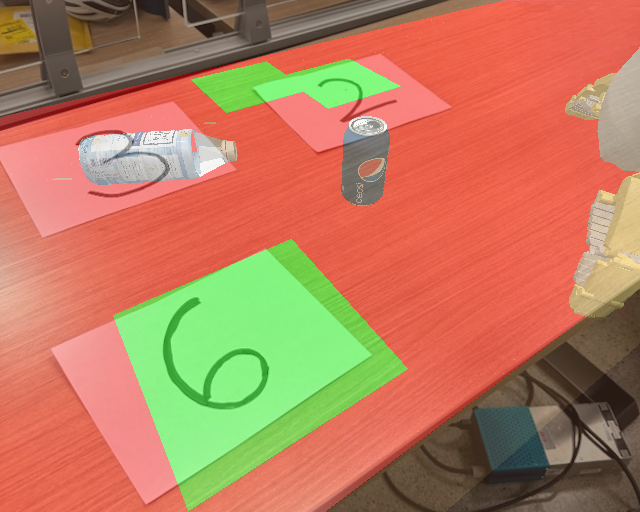

In [13]:
from sapien.core import Pose
from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
from PIL import Image
from IPython.display import display
obs = env.get_obs()
imgs = list(chain(*[ observations_to_images(cam_obs) for cam_obs in obs["image"].values()]))
display(Image.fromarray(imgs[4]))

In [ ]:
from sapien.core import Pose

def rerender(x=0.0, y=0.0, z=0.5, roll=0.0, pitch=0.0, yaw=0.0):
    # 1) re-pose the object
    my_obj.set_pose(Pose([x, y, z], euler2quat(roll, pitch, yaw)))

    # 2) grab an observation (runs your overlay logic)
    obs = env.get_obs()
    imgs = list(chain(*[ observations_to_images(cam_obs) for cam_obs in obs["image"].values()]))[4:]
    stacked = np.vstack(imgs)  # shape = (sum of heights, max_w, 3)

    # 6) display full‐resolution at a comfortable size
    H, W = stacked.shape[:2]
    dpi = 100
    scale = 0.8  # tweak this up/down to zoom in/out
    plt.figure(figsize=(W / dpi * scale, H / dpi * scale), dpi=dpi)
    plt.axis("off")
    plt.imshow(stacked)
    plt.show()

ui = widgets.interactive(
    rerender,
    x=widgets.FloatSlider(value=my_obj.get_pose().p[0], min=-1, max=1, step=0.01, description="X"),
    y=widgets.FloatSlider(value=my_obj.get_pose().p[1], min=-1, max=1, step=0.01, description="Y"),
    z=widgets.FloatSlider(value=my_obj.get_pose().p[2], min=0,  max=2, step=0.01, description="Z"),
    roll=widgets.FloatSlider(value=0.0,                min=-np.pi, max=np.pi, step=0.01, description="Roll"),
    pitch=widgets.FloatSlider(value=0.0,               min=-np.pi, max=np.pi, step=0.01, description="Pitch"),
    yaw=widgets.FloatSlider(value=0.0,                 min=-np.pi, max=np.pi, step=0.01, description="Yaw"),
)
display(ui)

interactive(children=(FloatSlider(value=-0.20000000298023224, description='X', max=1.0, min=-1.0, step=0.01), …

In [47]:
# ─── Cell 3: sliders + Maniskill2 helper for perfect overlay & tiling ─────────
from sapien.core import Pose
from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
from PIL import Image
from IPython.display import display

img = get_image_from_maniskill2_obs_dict(env, obs)  # uint8 H×W×3
display(Image.fromarray(img))
    

KeyError: 'rgb'